## 題目
以AAMI EC57標準進行心律異常預測
  
## 組員
徐愷駿(Keynes Hsu)、賴彥霖(Claire Lai)
  
## 資料集簡介
### MIT-BIH
MIT-BIH心律失常資料庫包含48個半小時的雙通道動態心電圖記錄摘錄，這些記錄來自1975年至1979年期間BIH心律失常實驗室研究的47名受試者。每條記錄有三個文件:1.注釋文件 2.信號文件 3.頭文件。
有三種數據存儲格式：

(1)  [.atr]：爲注釋檔。二進制存儲。通過這個文檔，我們可以讀取到相關beat的種類，如normal beat, RBBB beat等。

(2)  [.dat]：數據文件，按照二進制存儲，存儲著signal數據。每三個字節存儲兩個數，一個數12bits。

(3)  [.hea]：頭文件，存儲方式爲ASCII碼字符。可以使用瀏覽器直接打開，其中包括信號一些基本的常量。

Reference: http://www.physionet.org/physiobank/database/html/mitdbdir/mitdbdir.htm

### AMMI EC57資料集
ANSL／AAMI EC57：2012 是由美國醫療儀器促進協會(Association for the Advancement of Medical Instrumentation，AAMI)制定的一系列標準，包括心率失常的分類、心律失常分類檢測算法的評估標準等等。
AAMI規定心電節拍可以分爲五大類： 
- N(正常或者束支傳導阻滯節拍) 
- s(室上性異常節拍) 
- V(心室異常節拍) 
- F(融合節拍) 
- Q(未能分類的節拍) 
以及無法識讀的u類、輔助無法識讀標誌的x類和0類

AAMI還規定了心律失常分類檢測算法的評估標準，包括算法準確率的計算方法（混淆矩陣），以及準確率(Acc)、靈敏度(sen)、真陽性率(Ppr)等作爲衡量分類器分類性能的參數。通過混淆矩陣計算各個參數。
AAMI標準中指出Q類分類的準確率僅供參考，而u、x、0類不是真正的心電節拍，因此最終衡量分類算法的準確率是N、s、V、F類的心電節拍的Acc、Sen、Ppr。

![alt text](https://pic1.xuehuaimg.com/proxy/csdn/https://img-blog.csdn.net/20161203170506480)

## 實作方式
1.   取得MIT-BIH心率異常資料集
2.   MIT-BIH資料集的資料預處理
3.   心電圖影像以AAMI的標準格式進行心律異常的預測


## 專案時程
* 5/12 找題目
* 5/13 研究相關資料
* 5/16 瞭解AAMI EC57與MIT-BIH標準關係
* 5/22 Coding、訓練模型、抓蟲
* 5/27 驗證及修改
* 6/4 撰寫報告
* 6/7 報告繳交



---

## 程式

## 將Google drive掛載到Colab裡

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## 載入函式庫

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
import random
import pickle
import itertools

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error
from sklearn.utils import shuffle

#from scipy.signal import resample

from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation
from keras import backend as K_backend
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

np.random.seed(78)

Using TensorFlow backend.


## 載入MIT BIH資料集

In [0]:
df_mitbih_train = pd.read_csv("gdrive/My Drive/Colab Notebooks/heartbeat/mitbih_train.csv", header = None)
df_mitbih_test = pd.read_csv("gdrive/My Drive/Colab Notebooks/heartbeat/mitbih_test.csv", header = None)
df_concat = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)

In [4]:
df_concat.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [6]:
df_concat[187].value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: 187, dtype: int64

In [0]:
M = df_concat.values
X = M[:, :-1]
y = M[:, -1].astype(int)

In [0]:
VI0 = np.argwhere(y == 0).flatten()
VI1 = np.argwhere(y == 1).flatten()
VI2 = np.argwhere(y == 2).flatten()
VI3 = np.argwhere(y == 3).flatten()
VI4 = np.argwhere(y == 4).flatten()

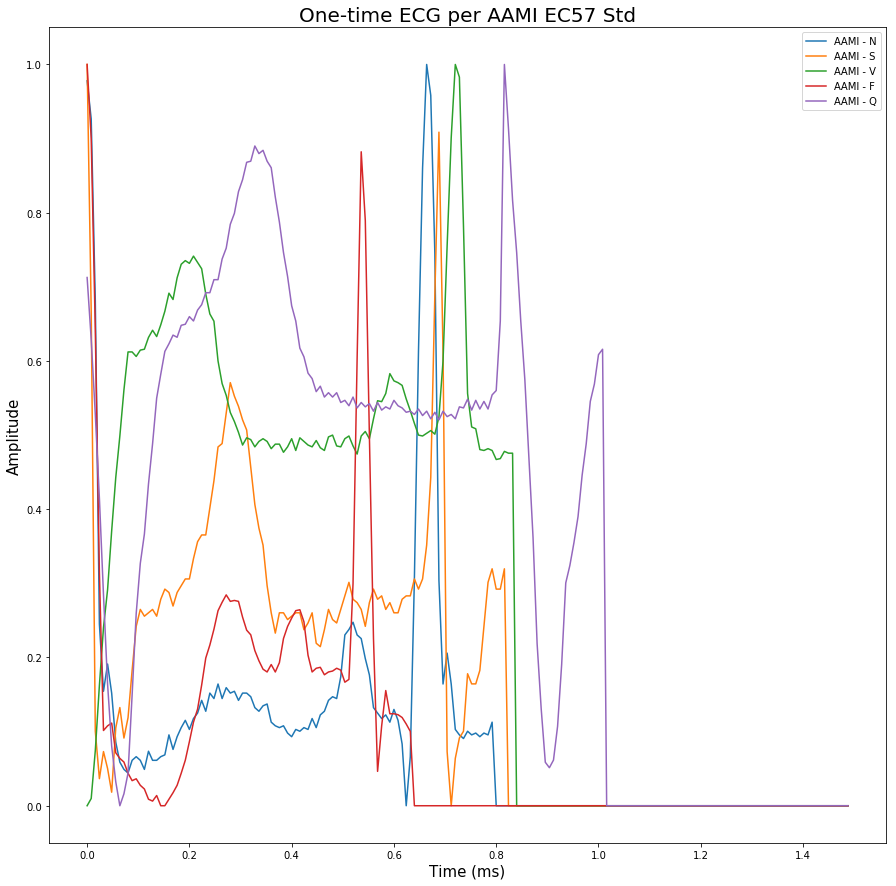

In [10]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(15,15))
plt.plot(x, X[VI0, :][0], label="AAMI - N")
plt.plot(x, X[VI1, :][0], label="AAMI - S")
plt.plot(x, X[VI2, :][0], label="AAMI - V")
plt.plot(x, X[VI3, :][0], label="AAMI - F")
plt.plot(x, X[VI4, :][0], label="AAMI - Q")
plt.legend()
plt.title("One-time ECG per AAMI EC57 Std", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

In [0]:
from scipy.signal import resample

def spread(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amp(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            spread_y = spread(x)
        elif random.random() < 0.66:
            spread_y = amp(x)
        else:
            spread_y = spread(x)
            spread_y = amp(spread_y)
        result[i, :] = spread_y
    return result

In [0]:
#plt.plot(X[0, :])
#plt.plot(amp(X[100, :]))
#plt.plot(spread(X[100, :]))
#plt.show()

In [0]:
result = np.apply_along_axis(augment, axis=1, arr=X[VI3]).reshape(-1, 187)
clas = np.ones(shape=(result.shape[0],), dtype=int)*3
X = np.vstack([X, result])
y = np.hstack([y, clas])

In [0]:
subVI0 = np.random.choice(VI0, 2500)
subVI1 = np.random.choice(VI1, 2500)
subVI2 = np.random.choice(VI2, 2500)
subVI3 = np.random.choice(VI3, 2500)
subVI4 = np.random.choice(VI4, 2500)

In [0]:
X_test = np.vstack([X[subVI0], X[subVI1], X[subVI2], X[subVI3], X[subVI4]])
y_test = np.hstack([y[subVI0], y[subVI1], y[subVI2], y[subVI3], y[subVI4]])

X_train = np.delete(X, [subVI0, subVI1, subVI2, subVI3, subVI4], axis=0)
y_train = np.delete(y, [subVI0, subVI1, subVI2, subVI3, subVI4], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [0]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [17]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (103608, 187, 1)
y_train (103608,)
X_test (12500, 187, 1)
y_test (12500,)


In [18]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## 建立CNN網路模型

In [0]:
n_obs, feature, depth = X_train.shape
batch_size = 800

In [20]:
K_backend.clear_session()

source_inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(source_inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)

C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)

C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)

C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)

C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

C61 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M51)
A61 = Activation("relu")(C61)
C62 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A61)
S61 = Add()([C62, M51])
A62 = Activation("relu")(S61)
M61 = MaxPooling1D(pool_size=5, strides=2)(A62)


F1 = Flatten()(M61)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=source_inp, outputs=A7)

Instructions for updating:
Colocations handled automatically by placer.


### 產生一張模型圖

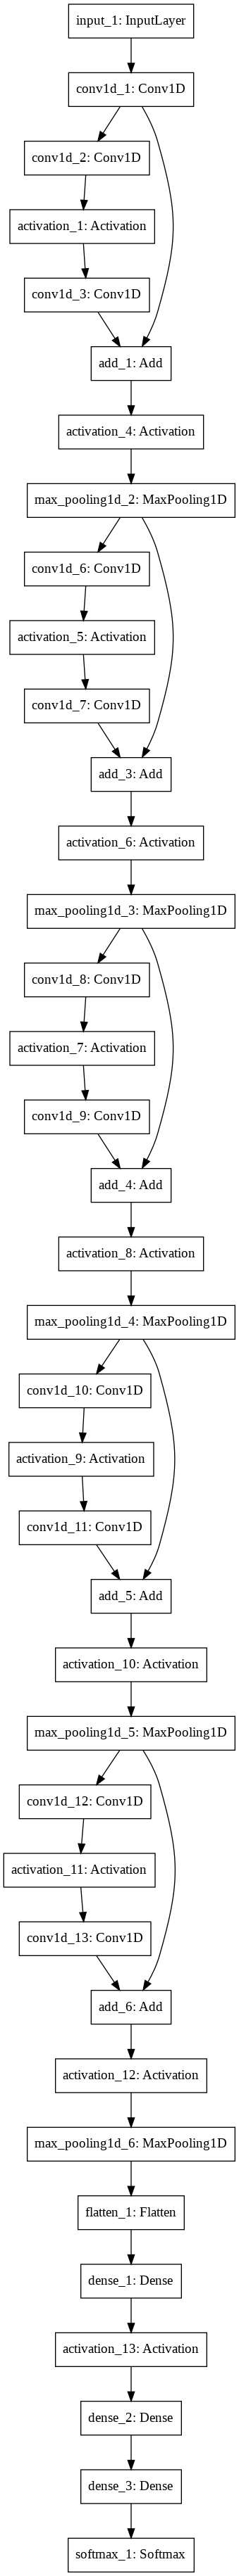

In [21]:
from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='gdrive/My Drive/Colab Notebooks/heartbeat/model_SVG.png')
Image(filename='gdrive/My Drive/Colab Notebooks/heartbeat/model_SVG.png')

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 187, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 183, 32)      5152        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 183, 32)      0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (

In [0]:
def e_decay(epoch):
    Initial_LearningRate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)
    hLearningRate = Initial_LearningRate * math.exp(-k*t)
    return hLearningRate

hLearningRate = LearningRateScheduler(e_decay)

In [0]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [25]:
his_fit = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(X_test, y_test), 
                    callbacks=[hLearningRate])

model.save('gdrive/My Drive/Colab Notebooks/heartbeat/Traing_History/his_fit_ep50.h5')
#his_fit_A1.load_weights('gdrive/My Drive/Colab Notebooks/heartbeat/his_fit_ep50.h5')

score = model.evaluate(X_train, y_train)
print()  
print("\t Accuracy of testing data = {:2.1f}%".format(score[1]*100.0))  

Instructions for updating:
Use tf.cast instead.
Train on 103608 samples, validate on 12500 samples
Epoch 1/50
 - 11s - loss: 0.3891 - acc: 0.8870 - val_loss: 1.2296 - val_acc: 0.6486
Epoch 2/50
 - 3s - loss: 0.1735 - acc: 0.9529 - val_loss: 1.0581 - val_acc: 0.6673
Epoch 3/50
 - 3s - loss: 0.1242 - acc: 0.9667 - val_loss: 0.6713 - val_acc: 0.8057
Epoch 4/50
 - 3s - loss: 0.0972 - acc: 0.9750 - val_loss: 0.6181 - val_acc: 0.8288
Epoch 5/50
 - 3s - loss: 0.0825 - acc: 0.9781 - val_loss: 0.5695 - val_acc: 0.8532
Epoch 6/50
 - 3s - loss: 0.0708 - acc: 0.9809 - val_loss: 0.5153 - val_acc: 0.8618
Epoch 7/50
 - 3s - loss: 0.0639 - acc: 0.9820 - val_loss: 0.5285 - val_acc: 0.8529
Epoch 8/50
 - 3s - loss: 0.0591 - acc: 0.9836 - val_loss: 0.4629 - val_acc: 0.8664
Epoch 9/50
 - 3s - loss: 0.0552 - acc: 0.9839 - val_loss: 0.5201 - val_acc: 0.8680
Epoch 10/50
 - 3s - loss: 0.0516 - acc: 0.9851 - val_loss: 0.4286 - val_acc: 0.8793
Epoch 11/50
 - 3s - loss: 0.0451 - acc: 0.9871 - val_loss: 0.4530 - v

In [0]:
y_pred = model.predict(X_test, batch_size=1000)

In [27]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      2500
           1       1.00      0.74      0.85      2500
           2       0.88      0.96      0.92      2500
           3       0.99      0.86      0.92      2500
           4       0.99      1.00      0.99      2500

    accuracy                           0.91     12500
   macro avg       0.92      0.91      0.91     12500
weighted avg       0.92      0.91      0.91     12500



In [28]:
print("ranking-based average precision : {:.3f}".format(label_ranking_average_precision_score(y_test.todense(), y_pred)))
print("Ranking loss : {:.3f}".format(label_ranking_loss(y_test.todense(), y_pred)))
print("Coverage_error : {:.3f}".format(coverage_error(y_test.todense(), y_pred)))

ranking-based average precision : 0.952
Ranking loss : 0.028
Coverage_error : 1.112


In [0]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
myfont = FontProperties(fname='gdrive/My Drive/Colab Notebooks/heartbeat/Microsoft-JhengHei.ttf', size=14)

## 利用混淆矩陣可以讓真實與預測數據的關係更具可讀性

Non-normalization confusion matrix


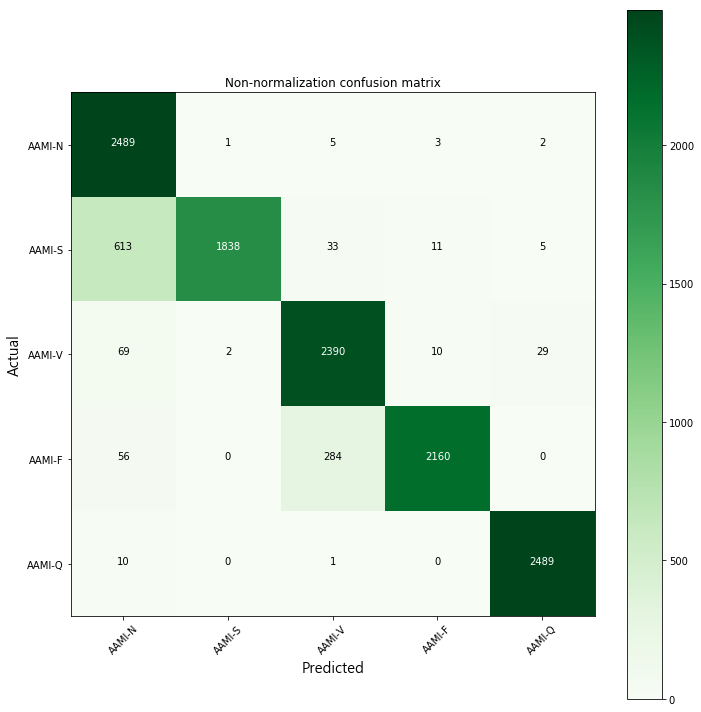

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Non-normalization confusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual', fontproperties = myfont)
    plt.xlabel('Predicted', fontproperties = myfont)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['AAMI-N', 'AAMI-S', 'AAMI-V', 'AAMI-F', 'AAMI-Q'],
                      title='Non-normalization confusion matrix')
plt.show()

## 結論
此專題使用六層的CNN網路模型針對約11萬筆數據進行分類及訓練，並以12500筆作為驗證。雖從準確率看來已相當不錯，但即便只有0.4%的錯誤率，從混淆矩陣來看，仍然會讓人有點懷疑人生。在預測值AAMI-S(室上性異常節拍)中有613筆被歸類為AAMI-N(正常或者束支傳導阻滯節拍))，AAMI-F(融合節拍)有284筆被歸類到AAMI-V(心室異常節拍) ，產生此問題有可能是心電圖影相對應或預處理的問題，仍需繼續探討或改善資料的預處理，亦可嘗試其他不同的神經網路模型進行訓練和減少epochs次數而能提高準確率。

## 參考資料


---
1.   ECG Heartbeat Categorization Dataset 
(https://www.kaggle.com/shayanfazeli/heartbeat)

2.   MIT-BIH ECG 心電資料的下載和讀取圖解 LightWAVE
(https://www.physionet.org/lightwave/)

